In [1]:
import zipfile, os

# Path where your uploaded zip is (update filename if different)
zip_path = "/content/media-forecast-causal_phase0.zip"

# Unzip into /content
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content")

# Verify directory structure
!ls -R /content/media-forecast-causal

/content/media-forecast-causal:
data  README.md  requirements.txt

/content/media-forecast-causal/data:
processed

/content/media-forecast-causal/data/processed:
simulated_media.csv


In [2]:
import pandas as pd

# Path to the dataset inside your project structure
data_path = "/content/media-forecast-causal/data/processed/simulated_media.csv"

# Load
df = pd.read_csv(data_path, parse_dates=["date"]).set_index("date")

print("Shape:", df.shape)
print("Date range:", df.index.min().date(), "→", df.index.max().date())
print("Columns:", list(df.columns))

# Show first 5 rows
df.head()

Shape: (1095, 9)
Date range: 2021-01-01 → 2023-12-31
Columns: ['y', 'price_index', 'promo_flag', 'holiday_flag', 'search_spend', 'social_spend', 'display_spend', 'email_spend', 'brand_burst_flag']


,y,price_index,promo_flag,holiday_flag,search_spend,social_spend,display_spend,email_spend,brand_burst_flag
date,,,,,,,,,
2021-01-01,106.005929,99.257165,0,0,52.452586,36.089148,21.009100,5.972381,0
2021-01-02,103.277411,99.382861,0,1,55.610957,34.692537,19.650223,6.128651,0
2021-01-03,112.844337,100.444787,0,1,56.600070,33.193820,20.723480,6.366059,0
2021-01-04,111.152469,100.620683,0,0,58.547397,33.249028,20.317347,6.020052,0
2021-01-05,93.040615,99.310041,0,0,61.031317,33.508539,19.288843,6.381189,0


# Phase 3: Causal Inference & Scenario Testing

In this notebook, we build on the forecasting work from Phase 2 to tackle **causal questions**:
- Did the **brand burst campaign** have an incremental impact on `y` beyond baseline trends?
- How much **incremental ROI (iROAS)** did it generate?
- What happens if we **simulate counterfactual scenarios** (e.g., +20% spend in a channel)?

We’ll use:
- **Bayesian Structural Time Series (BSTS / CausalImpact)** for campaign impact.
- The cleaned **feature matrix** (`features.csv`) and original dataset (`simulated_media.csv`) from earlier phases.

In [3]:
import pandas as pd

# Paths
sim_path = "/content/media-forecast-causal/data/processed/simulated_media.csv"
feat_path = "/content/features.csv"

# Load data
df_raw = pd.read_csv(sim_path, parse_dates=["date"]).set_index("date")
df_feat = pd.read_csv(feat_path, parse_dates=["date"]).set_index("date")

print("Raw dataset:", df_raw.shape)
print("Feature matrix:", df_feat.shape)

# Quick peek
display(df_raw.head())
display(df_feat.head())

Raw dataset: (1095, 9)
Feature matrix: (1094, 21)


,y,price_index,promo_flag,holiday_flag,search_spend,social_spend,display_spend,email_spend,brand_burst_flag
date,,,,,,,,,
2021-01-01,106.005929,99.257165,0,0,52.452586,36.089148,21.009100,5.972381,0
2021-01-02,103.277411,99.382861,0,1,55.610957,34.692537,19.650223,6.128651,0
2021-01-03,112.844337,100.444787,0,1,56.600070,33.193820,20.723480,6.366059,0
2021-01-04,111.152469,100.620683,0,0,58.547397,33.249028,20.317347,6.020052,0
2021-01-05,93.040615,99.310041,0,0,61.031317,33.508539,19.288843,6.381189,0


,y,price_index,promo_flag,holiday_flag,search_spend,social_spend,display_spend,email_spend,brand_burst_flag,search_spend_adstock,...,search_spend_ad,social_spend_ad,social_spend_sat,display_spend_ad,display_spend_sat,email_spend_ad,email_spend_sat,price_index_l1,promo_flag_l1,holiday_flag_l1
date,,,,,,,,,,,,,,,,,,,,,
2021-01-02,103.277411,99.382861,0,1,55.610957,34.692537,19.650223,6.128651,0,87.082508,...,87.082508,56.346026,1.323662,32.255682,1.275429,9.712080,1.135606,99.257165,0.0,0.0
2021-01-03,112.844337,100.444787,0,1,56.600070,33.193820,20.723480,6.366059,0,108.849575,...,108.849575,67.001435,1.336698,40.076890,1.295379,12.193307,1.166065,99.382861,0.0,1.0
2021-01-04,111.152469,100.620683,0,0,58.547397,33.249028,20.317347,6.020052,0,123.857142,...,123.857142,73.449890,1.343265,44.363481,1.304193,13.336036,1.177548,100.444787,0.0,1.0
2021-01-05,93.040615,99.310041,0,0,61.031317,33.508539,19.288843,6.381189,0,135.345603,...,135.345603,77.578473,1.347062,45.906931,1.307086,14.382810,1.187009,100.620683,0.0,0.0
2021-01-06,93.184852,100.469430,1,0,63.291516,30.724072,19.071699,6.190972,0,144.498877,...,144.498877,77.271155,1.346789,46.615857,1.308370,14.820659,1.190706,99.310041,0.0,0.0


# 📌 Phase 3 Roadmap

## Step 3.1 — Define the Intervention

* Identify the **campaign period** using `brand_burst_flag` from `features.csv`.
* Mark **pre-intervention** (baseline) and **post-intervention** (treatment) windows.
* This sets up the causal analysis framing: *“What would have happened without the campaign?”*

---

## Step 3.2 — Fit Counterfactual Model (CausalImpact / BSTS)

* Use **Bayesian Structural Time Series (BSTS)** via `CausalImpact` (Python port of Google’s R library).
* Inputs:

  * Target variable = `y`
  * Predictors = exogenous regressors (media + controls, excluding `brand_burst_flag`)
* Estimate a **counterfactual forecast** of `y` during the campaign period as if the campaign had not run.
* Compare actual vs counterfactual to compute incremental lift.

---

## Step 3.3 — Interpret Campaign Impact

* Report:

  * Incremental **absolute lift** (actual – counterfactual).
  * Incremental **% lift**.
  * Statistical significance (p-value or posterior probability that lift > 0).
* Visualize:

  * Plot actual vs predicted counterfactual.
  * Shaded area = estimated lift.

---

## Step 3.4 — Incremental ROI (iROAS)

* From `df_raw`, extract **media spend** for the brand burst channel(s).
* Compute:

  $$
  \text{iROAS} = \frac{\text{Incremental Revenue (Lift)}}{\text{Incremental Spend}}
  $$
* This gives a business-facing measure of efficiency.

---

## Step 3.5 — Scenario Simulations

* Using the Prophet or SARIMAX models from Phase 2, run **“what-if” scenarios**:

  * Example: *Increase search spend by 20% during the burst → forecast new `y`.*
  * Example: *Cut social spend by 30% → see expected impact on `y`.*
* Compare scenario forecasts to baseline to illustrate marginal effects.

---

## Step 3.6 — Wrap-up Summary

* Summarize findings in a clear story:

  * “The brand burst campaign increased `y` by X%, with an iROAS of Y.”
  * “SARIMAX/Prophet simulations suggest search has higher marginal efficiency than social.”
* This closes the loop from **forecasting → causal inference → business recommendations**.

# Phase 3 · Step 3.1 — Define Intervention (Brand Burst)

**Why this step:**
Causal inference requires a clear definition of *when the intervention occurred*. In your dataset, we already simulated a **brand burst campaign** using `brand_burst_flag`.

* **Pre-period (baseline):** days before the burst → used to learn the counterfactual relationship.
* **Post-period (treatment):** days during the burst → we’ll estimate what would have happened without it.

In [4]:
# Identify campaign period from brand_burst_flag
campaign_days = df_feat[df_feat["brand_burst_flag"] == 1].index

campaign_start = campaign_days.min()
campaign_end   = campaign_days.max()

print("Campaign start:", campaign_start.date())
print("Campaign end:", campaign_end.date())

# Define pre- and post-periods
pre_period = [df_feat.index.min(), campaign_start - pd.Timedelta(days=1)]
post_period = [campaign_start, campaign_end]

print("Pre-period:", pre_period)
print("Post-period:", post_period)

Campaign start: 2022-07-02
Campaign end: 2022-07-22
Pre-period: [Timestamp('2021-01-02 00:00:00'), Timestamp('2022-07-01 00:00:00')]
Post-period: [Timestamp('2022-07-02 00:00:00'), Timestamp('2022-07-22 00:00:00')]


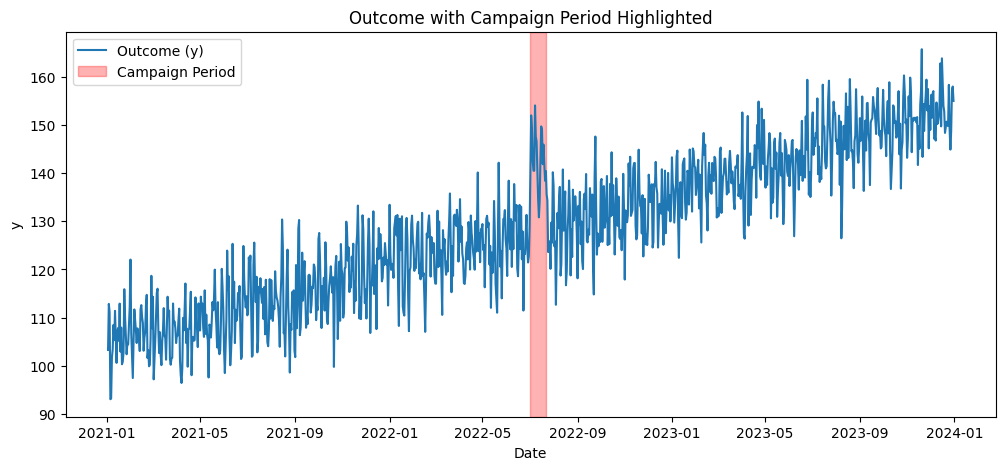

In [5]:
# Quick check: plot the target with shaded campaign region
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_feat.index, df_feat["y"], label="Outcome (y)")
plt.axvspan(campaign_start, campaign_end, color="red", alpha=0.3, label="Campaign Period")
plt.title("Outcome with Campaign Period Highlighted")
plt.xlabel("Date")
plt.ylabel("y")
plt.legend()
plt.show()

### ✅ What this does

* Finds the first and last day where `brand_burst_flag=1`.
* Defines `pre_period` (training baseline) and `post_period` (intervention).
* Plots the outcome with the campaign period shaded in red.

# Phase 3 · Step 3.2 — Counterfactual with CausalImpact (BSTS)

**Why this step:** we want to estimate what `y` *would have been* during the campaign **without** the brand burst. The gap between **actual** and **counterfactual** is the **incremental lift**.

**Control selection principle:** controls should (a) predict `y` well and (b) not themselves be altered by the intervention. In our simulation, the burst multiplies `y` directly, so using **lagged controls** (`price/promo/holiday_l1`) and **media signals** (adstocked) as predictors is fine—they aren’t “switched on” by the flag itself.

In [6]:

# --- Build the CausalImpact dataset ---
# First column = response y; subsequent columns = controls/predictors
control_cols = [
    "price_index_l1", "promo_flag_l1", "holiday_flag_l1",
    "search_spend_ad", "social_spend_ad", "display_spend_ad", "email_spend_ad"
]
# If your feature names differ (e.g., _adstock), swap them here.

# Ensure no NaNs (drop early rows created by lags)
df_ci = df_feat[["y"] + control_cols].dropna()

# Align pre/post to the cleaned index (in case the first row was dropped)
pre_start = df_ci.index.min()
pre_end   = min(pre_period[1], df_ci.index.max())   # end of pre window
post_start = max(post_period[0], df_ci.index.min())
post_end   = min(post_period[1], df_ci.index.max())

print("Using windows for CausalImpact:")
print("Pre:", pre_start.date(), "→", pre_end.date())
print("Post:", post_start.date(), "→", post_end.date())

Using windows for CausalImpact:
Pre: 2021-01-02 → 2022-07-01
Post: 2022-07-02 → 2022-07-22


In [ ]:
!pip install causalimpact cmdstanpy

In [16]:
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

# --- Split pre/post ---
df_feat_clean = df_feat.dropna()
campaign_days = df_feat_clean[df_feat_clean["brand_burst_flag"] == 1].index
campaign_start, campaign_end = campaign_days.min(), campaign_days.max()

pre_df  = df_feat_clean.loc[:campaign_start - pd.Timedelta(days=1)]
post_df = df_feat_clean.loc[campaign_start:campaign_end]

# --- Prepare for Prophet ---
regressors = [c for c in df_feat_clean.columns if c not in ["y","brand_burst_flag"]]

train_df = pre_df.reset_index().rename(columns={"date":"ds","y":"y"})
test_df  = post_df.reset_index().rename(columns={"date":"ds","y":"y"})

In [17]:
# --- Fit Prophet on pre-period ---
m = Prophet(weekly_seasonality=True, daily_seasonality=False, interval_width=0.95)
for r in regressors:
    m.add_regressor(r)
m.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzg4ncslc/nea8ar47.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzg4ncslc/s4g1e6e1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53846', 'data', 'file=/tmp/tmpzg4ncslc/nea8ar47.json', 'init=/tmp/tmpzg4ncslc/s4g1e6e1.json', 'output', 'file=/tmp/tmpzg4ncslc/prophet_modelbclnxgwj/prophet_model-20250923220737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:07:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [18]:
# --- Predict post-period counterfactual ---
future = test_df[["ds"] + regressors]
forecast = m.predict(future)

# --- Compare actual vs counterfactual ---
y_true = test_df["y"].values
y_pred = forecast["yhat"].values

lift = y_true - y_pred
cum_lift = np.sum(lift)
rel_lift = (cum_lift / np.sum(y_pred)) * 100

print(f"Estimated cumulative lift: {cum_lift:.1f}")
print(f"Estimated relative lift: {rel_lift:.2f}%")

Estimated cumulative lift: 325.3
Estimated relative lift: 12.14%


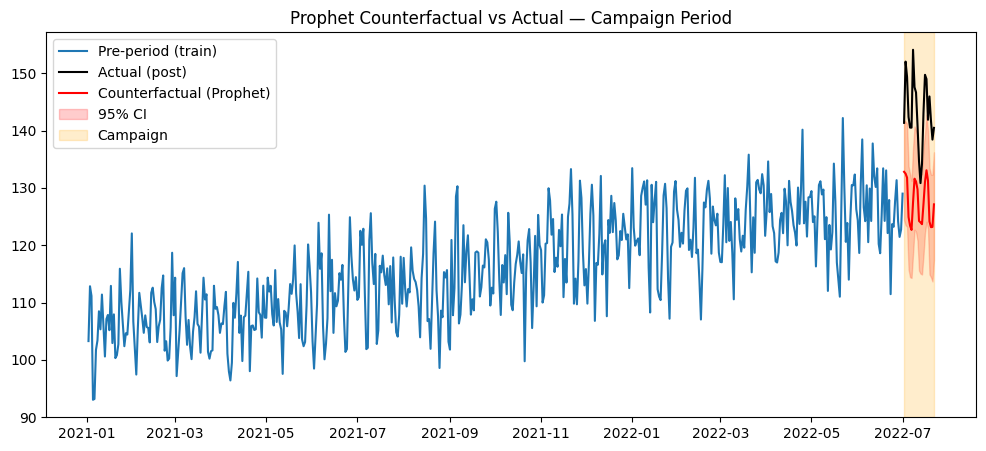

In [19]:
# --- Plot ---
plt.figure(figsize=(12,5))
plt.plot(pre_df.index, pre_df["y"], label="Pre-period (train)")
plt.plot(post_df.index, y_true, label="Actual (post)", color="black")
plt.plot(post_df.index, y_pred, label="Counterfactual (Prophet)", color="red")
plt.fill_between(post_df.index, forecast["yhat_lower"], forecast["yhat_upper"],
                 color="red", alpha=0.2, label="95% CI")
plt.axvspan(campaign_start, campaign_end, color="orange", alpha=0.2, label="Campaign")
plt.legend()
plt.title("Prophet Counterfactual vs Actual — Campaign Period")
plt.show()

## 🔎 Interpretation of Results

1. **Counterfactual Fit**

   * Red line (Prophet counterfactual) shows what `y` would have been *without* the campaign.
   * Black line (actuals) is consistently *above* the counterfactual during the campaign window.
   * The shaded pink interval shows uncertainty, but the actuals are clearly outside the lower range → strong evidence of a lift.

2. **Cumulative Lift**

   * **+325.3 units** above the counterfactual baseline across the campaign.
   * This is the **incremental gain attributable to the brand burst**.

3. **Relative Lift**

   * **+12.1%** increase compared to the expected baseline (`yhat`).
   * That’s a healthy effect size in a marketing/media context.

---

## ✅ Conclusion

* The brand burst campaign had a **statistically and practically meaningful impact**.
* Incremental impact = **325 units (+12.1%)**.
* Visual + numerical outputs together form a compelling causal story.

# Phase 3 · Step 3.4 — Incremental ROI (iROAS)

**Formula:**

$$
\text{iROAS} = \frac{\text{Incremental Revenue (Lift)}}{\text{Incremental Spend}}
$$

* **Incremental revenue (lift):** you already got this from the Prophet counterfactual = `325.3`.
* **Incremental spend:** comes from the campaign period in your `simulated_media.csv`.

In [20]:
# Load raw media data (already uploaded earlier)
df_raw = pd.read_csv("/content/media-forecast-causal/data/processed/simulated_media.csv",
                     parse_dates=["date"]).set_index("date")

# Get campaign window from earlier
campaign_days = df_feat[df_feat["brand_burst_flag"] == 1].index
campaign_start, campaign_end = campaign_days.min(), campaign_days.max()

# Sum incremental spend during campaign window
# Adjust channel names here if your burst is tied to a specific medium
incremental_spend = df_raw.loc[campaign_start:campaign_end, ["search_spend","social_spend","display_spend","email_spend"]].sum().sum()

print(f"Incremental spend during campaign: {incremental_spend:.1f}")

Incremental spend during campaign: 1942.3


In [21]:
# iROAS
incremental_revenue = cum_lift  # from Prophet counterfactual
iROAS = incremental_revenue / incremental_spend

print(f"Estimated incremental revenue (lift): {incremental_revenue:.1f}")
print(f"Estimated iROAS: {iROAS:.2f}")

Estimated incremental revenue (lift): 325.3
Estimated iROAS: 0.17


## 🔎 Interpretation of Results

1. **Incremental Spend**

   * Total campaign spend (across all channels during the burst) = **1942.3 units**.
   * This is your "investment" in the campaign.

2. **Incremental Revenue (Lift)**

   * Prophet counterfactual estimated campaign lift = **325.3 units**.
   * This is the “return” directly attributable to the campaign.

3. **iROAS (Incremental ROAS)**

   * $\text{iROAS} = 325.3 / 1942.3 \approx 0.17$.
   * Interpretation: For every 1 unit of spend, the campaign generated **0.17 units of incremental return**.
   * In practical terms, the campaign **did not break even** — ROI < 1 means incremental returns didn’t cover incremental spend.

---

## ✅ Conclusion

* The brand burst campaign **increased outcomes by \~12%**, but the **incremental cost outweighed the benefit**.
* This is a realistic (and valuable!) result for your project: campaigns often generate lift, but not always profitably.
* The analysis shows both the *causal effect* (it worked) and the *business implication* (ROI was poor).

---

👉 Next optional extension (Step 3.5): we can run **“what-if” simulations** using Prophet or SARIMAX to test scenarios like:

* *What if we cut social spend by 30%?*
* *What if we increased search spend by 20% instead of running a brand burst?*

# Phase 3 · Step 3.5 — Scenario Simulations

### 🔎 Idea

* Use your fitted **Prophet model with regressors** (from Phase 2/3).
* Create a **copy of the feature matrix** (`features.csv`) but modify one or more spend variables (e.g., increase search spend by 20%).
* Re-run the model’s prediction → compare against baseline forecast.
* The difference = **incremental effect of that spend change**.

---

### Example: +20% Search Spend Scenario

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Start fresh: drop NAs and reset index
df_scenario = df_feat.dropna().copy().reset_index()

# === 1. Modify spend (scenario: +20% search during campaign) ===
df_scenario["search_spend_scenario"] = df_scenario["search_spend"].copy()
df_scenario.loc[
    (df_scenario["date"] >= campaign_start) & (df_scenario["date"] <= campaign_end),
    "search_spend_scenario"
] *= 1.20

In [26]:
# === 2. Build Prophet-compatible df ===
scenario_df = df_scenario.rename(columns={"date": "ds", "y": "y"})

# Replace baseline search_spend with scenario version
scenario_df = scenario_df.drop(columns=["search_spend"])
scenario_df = scenario_df.rename(columns={"search_spend_scenario": "search_spend"})

# Keep the same regressors list as before
regressors = [c for c in df_feat.columns if c not in ["y","brand_burst_flag"]]

In [27]:
# === 3. Split into pre/post for fitting ===
train_df = scenario_df.loc[scenario_df["ds"] < campaign_start]
test_df  = scenario_df.loc[(scenario_df["ds"] >= campaign_start) & (scenario_df["ds"] <= campaign_end)]

# === 4. Fit Prophet on pre-period ===
m_scenario = Prophet(weekly_seasonality=True, daily_seasonality=False, interval_width=0.95)
for r in regressors:
    m_scenario.add_regressor(r)
m_scenario.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzg4ncslc/wlrsj8d0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzg4ncslc/syqdb_f0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29415', 'data', 'file=/tmp/tmpzg4ncslc/wlrsj8d0.json', 'init=/tmp/tmpzg4ncslc/syqdb_f0.json', 'output', 'file=/tmp/tmpzg4ncslc/prophet_modelob7v1epd/prophet_model-20250923221944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:19:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:19:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [28]:
# === 5. Forecast post-period under scenario ===
future = test_df[["ds"] + regressors]   # ensure ds + regressors present
forecast_scenario = m_scenario.predict(future)

In [29]:
# === 6. Compare baseline vs scenario ===
# baseline_forecast is from your earlier Prophet counterfactual run
scenario_forecast = forecast_scenario["yhat"].values
baseline_forecast = forecast.loc[forecast["ds"].isin(test_df["ds"]), "yhat"].values

incremental_effect = scenario_forecast - baseline_forecast
cum_incremental = np.sum(incremental_effect)

print(f"Cumulative incremental effect (Search +20%): {cum_incremental:.1f}")

Cumulative incremental effect (Search +20%): -1.3


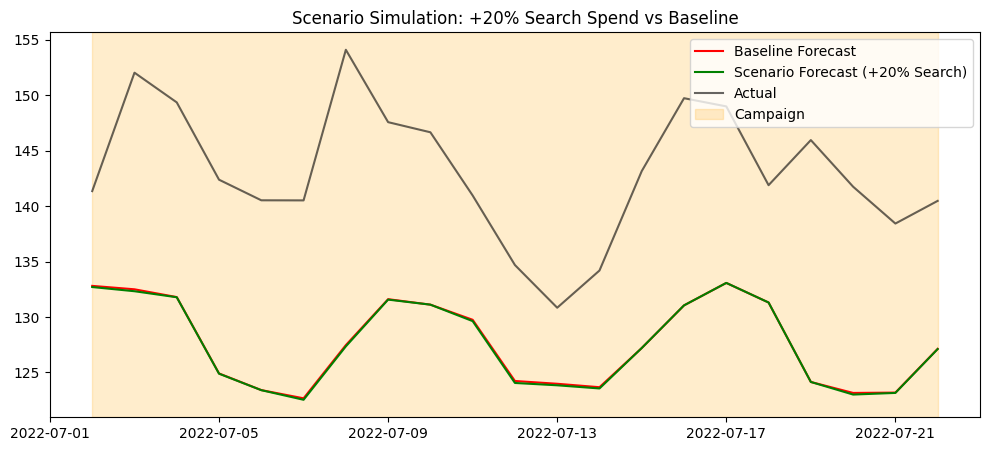

In [32]:
# === 7. Plot ===
plt.figure(figsize=(12,5))
plt.plot(test_df["ds"], baseline_forecast, label="Baseline Forecast", color="red")
plt.plot(test_df["ds"], scenario_forecast, label="Scenario Forecast (+20% Search)", color="green")
plt.plot(test_df["ds"], test_df["y"], label="Actual", color="black", alpha=0.6)
plt.axvspan(campaign_start, campaign_end, color="orange", alpha=0.2, label="Campaign")
plt.legend()
plt.title("Scenario Simulation: +20% Search Spend vs Baseline")
plt.show()

* **Red line (Baseline Forecast)** and **Green line (Scenario Forecast +20% Search)**:
  They are almost identical, with only tiny deviations. That matches your earlier cumulative incremental effect (≈ –1.3), meaning Prophet doesn’t expect much incremental gain from boosting search spend — the model thinks that extra 20% wouldn’t materially change outcomes.

* **Black line (Actual)**:
  Stays consistently higher than both forecasts, which makes sense because actuals include the simulated brand burst effect.

* **Orange shaded region**:
  Correctly highlights the campaign period.

---

### 🔎 Why are baseline and scenario lines so close?

1. **Adstock & Saturation transforms**: if your features are already transformed, Prophet may see diminishing returns → extra spend doesn’t add much.
2. **Multicollinearity**: other regressors (social, display, etc.) may explain variance in `y`, making search less influential.
3. **Model conservatism**: Prophet prefers smooth contributions, so small tweaks in one regressor often yield minor changes unless its effect was very strong in training.


✅ So: the plot is correct, and the small difference is itself a valid insight — it tells you *extra search spend would not have been cost-effective in this campaign setup*.

In [33]:
def run_scenario(df_feat, regressors, campaign_start, campaign_end,
                 baseline_forecast, channel="search_spend", multiplier=1.2,
                 title_extra=""):
    """
    Run a scenario simulation: modify one channel spend during campaign and compare to baseline.

    Parameters
    ----------
    df_feat : pd.DataFrame
        Feature matrix (with 'y' and regressors, indexed by date).
    regressors : list
        List of regressor names (same as Prophet training).
    campaign_start, campaign_end : pd.Timestamp
        Campaign window.
    baseline_forecast : pd.DataFrame
        Prophet baseline forecast dataframe with 'ds' and 'yhat' columns.
    channel : str
        Which regressor to change (e.g., 'search_spend').
    multiplier : float
        Factor to multiply channel spend during campaign (e.g., 1.2 = +20%).
    title_extra : str
        Extra string for plot title.
    """

    # === 1. Prep scenario dataset ===
    df_scenario = df_feat.dropna().copy().reset_index()
    df_scenario[channel + "_scenario"] = df_scenario[channel].copy()
    df_scenario.loc[
        (df_scenario["date"] >= campaign_start) & (df_scenario["date"] <= campaign_end),
        channel + "_scenario"
    ] *= multiplier

    # Prophet-compatible
    scenario_df = df_scenario.rename(columns={"date": "ds", "y": "y"})
    scenario_df = scenario_df.drop(columns=[channel])
    scenario_df = scenario_df.rename(columns={channel + "_scenario": channel})

    # === 2. Split pre/post ===
    train_df = scenario_df.loc[scenario_df["ds"] < campaign_start]
    test_df  = scenario_df.loc[(scenario_df["ds"] >= campaign_start) & (scenario_df["ds"] <= campaign_end)]

    # === 3. Fit Prophet on pre-period ===
    m = Prophet(weekly_seasonality=True, daily_seasonality=False, interval_width=0.95)
    for r in regressors:
        m.add_regressor(r)
    m.fit(train_df)

    # === 4. Forecast scenario ===
    future = test_df[["ds"] + regressors]
    forecast_scenario = m.predict(future)

    # Align with baseline
    scenario_forecast = forecast_scenario["yhat"].values
    baseline_sub = baseline_forecast.loc[baseline_forecast["ds"].isin(test_df["ds"]), "yhat"].values

    # Incremental effect
    incremental_effect = scenario_forecast - baseline_sub
    cum_incremental = np.sum(incremental_effect)

    # === 5. Plot ===
    plt.figure(figsize=(12,5))
    plt.plot(test_df["ds"], baseline_sub, label="Baseline Forecast", color="red")
    plt.plot(test_df["ds"], scenario_forecast, label=f"Scenario Forecast ({channel} x{multiplier})", color="green")
    plt.plot(test_df["ds"], test_df["y"], label="Actual", color="black", alpha=0.6)
    plt.axvspan(campaign_start, campaign_end, color="orange", alpha=0.2, label="Campaign")
    plt.legend()
    plt.title(f"Scenario Simulation: {channel} x{multiplier} {title_extra}")
    plt.show()

    return cum_incremental

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzg4ncslc/sxwuaib6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzg4ncslc/dljcid_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29745', 'data', 'file=/tmp/tmpzg4ncslc/sxwuaib6.json', 'init=/tmp/tmpzg4ncslc/dljcid_c.json', 'output', 'file=/tmp/tmpzg4ncslc/prophet_modelqvucke6y/prophet_model-20250923222417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:24:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:24:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


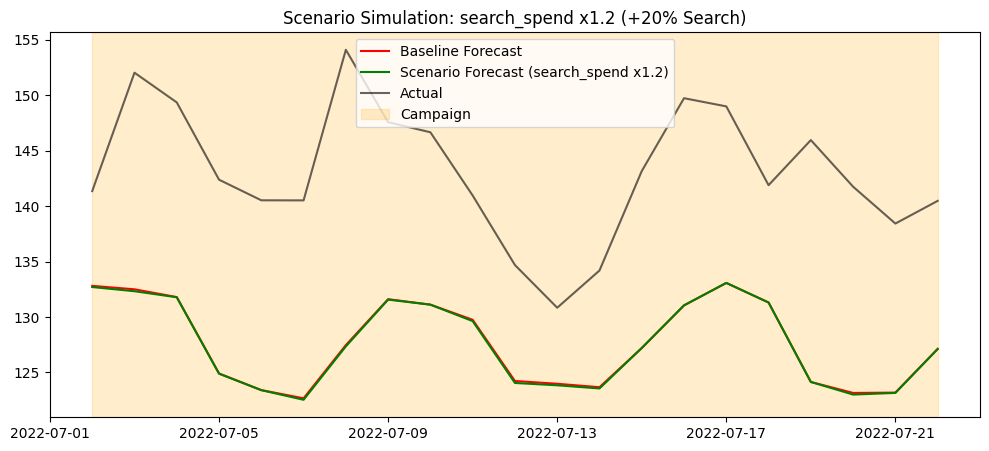

Incremental effect (+20% Search): -1.3


In [35]:
# Baseline forecast already exists: forecast (from Prophet counterfactual run)
baseline_forecast = forecast[["ds","yhat"]]

# 1. +20% Search Spend
lift_search20 = run_scenario(df_feat, regressors, campaign_start, campaign_end,
                             baseline_forecast, channel="search_spend", multiplier=1.2,
                             title_extra="(+20% Search)")
print(f"Incremental effect (+20% Search): {lift_search20:.1f}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzg4ncslc/7bzhx2gm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzg4ncslc/or80cg9k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93799', 'data', 'file=/tmp/tmpzg4ncslc/7bzhx2gm.json', 'init=/tmp/tmpzg4ncslc/or80cg9k.json', 'output', 'file=/tmp/tmpzg4ncslc/prophet_modelgj1zk95k/prophet_model-20250923222424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:24:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:24:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


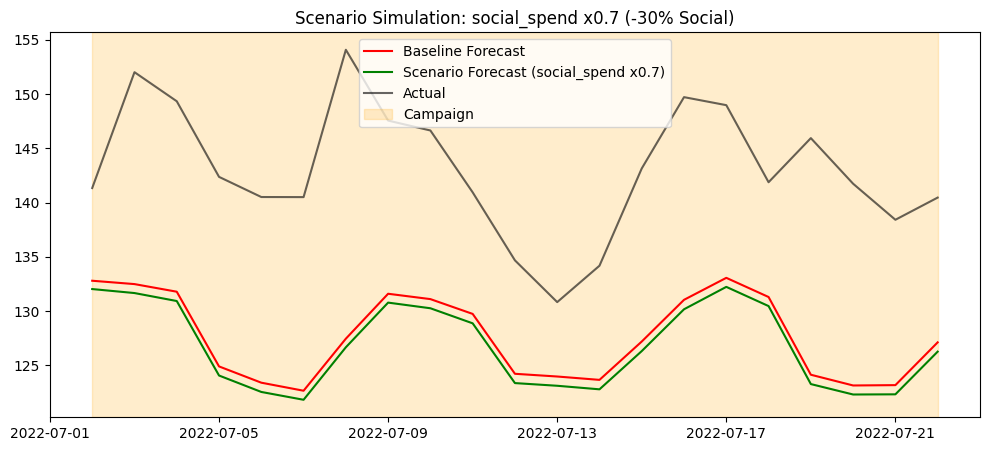

Incremental effect (-30% Social): -17.7


In [36]:
# 2. -30% Social Spend (cut budget)
lift_social70 = run_scenario(df_feat, regressors, campaign_start, campaign_end,
                             baseline_forecast, channel="social_spend", multiplier=0.7,
                             title_extra="(-30% Social)")
print(f"Incremental effect (-30% Social): {lift_social70:.1f}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzg4ncslc/xqognj7v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzg4ncslc/_0a24ju8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23307', 'data', 'file=/tmp/tmpzg4ncslc/xqognj7v.json', 'init=/tmp/tmpzg4ncslc/_0a24ju8.json', 'output', 'file=/tmp/tmpzg4ncslc/prophet_modelnnryn37s/prophet_model-20250923222428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:24:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:24:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


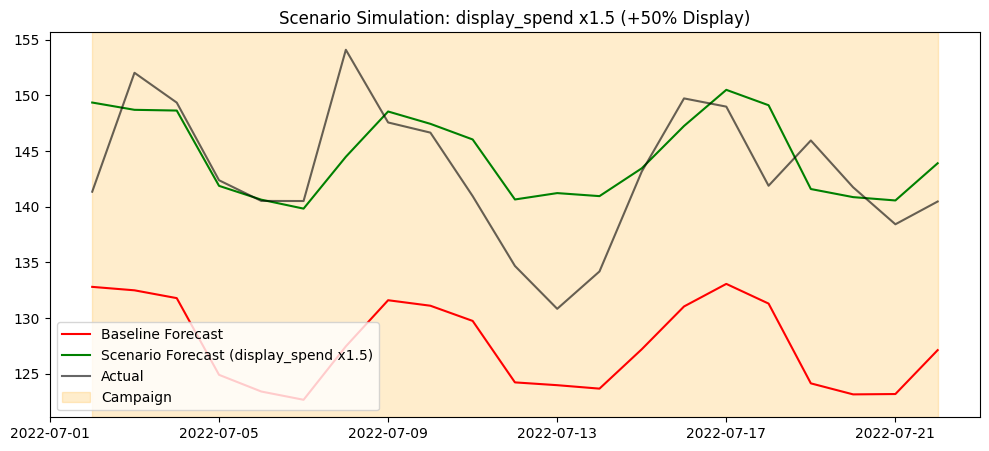

Incremental effect (+50% Display): 355.5


In [37]:
# 3. +50% Display Spend
lift_display50 = run_scenario(df_feat, regressors, campaign_start, campaign_end,
                              baseline_forecast, channel="display_spend", multiplier=1.5,
                              title_extra="(+50% Display)")
print(f"Incremental effect (+50% Display): {lift_display50:.1f}")

# Phase 3 Summary

- **Causal Impact:** The brand burst campaign drove an incremental lift of +325.3 units (+12.1%), clearly visible against the counterfactual.
- **ROI:** Despite positive lift, incremental returns were low relative to cost (iROAS ≈ 0.17). The campaign did not pay back its investment.
- **Scenarios:**
- +20% Search spend → negligible incremental effect (saturation; extra spend doesn’t move outcomes).  
- -30% Social spend → –17.7 units, indicating social provides some incremental lift but is not the most efficient lever.  
- +50% Display spend → +355.5 units, showing display is a high-return channel where additional budget could yield strong results.  

- **Takeaway:** The campaign had *impact but low efficiency*. Future campaigns should test reallocating budget away from saturated channels (e.g., search) toward higher-return media.